In [1]:
##########################
# Cool Star Lab, UCSD    #
# Joman, 8. July, 2022   #
##########################

In [2]:
###########
# imports #
###########

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import os.path
import splat
from splat.plot import plotSpectrum
from scipy import stats as scipy
import math

#!pip install astroquery # we need to install astroquery on our machine
# !pip install astroquery raises an "error: missing requirement"
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch

from astropy.io import ascii # we'll use this to upload files
import astropy.units as u # units
from astropy.coordinates import SkyCoord # astropy coordinate object
from astropy.table import Table



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/


Could not import regions, which is required for some of the functionalities of this module.


In [3]:
########
# VARS #
########
DEMEO_CLASSES = ['A', 'B', 'C', 'Cb', 'Cg','Cgh', 'Ch', 'D', 'K', 'L', 'O', 'Q', 'R','S', 'Sa', 'Sq', 'Sr', 'Sv', 'T', 'V', 'X', 'Xc', 'Xe', 'Xk']

In [28]:
#############
# functions #
#############

def saveTemplate(directory: str, saveName: str, classNames): #need revision, update: 'one step' is working
#     if not delim: #defaults separation to one space
#         delim = ' '
    
    saveFolderName = saveName + '_Folder'
    
    #check if save location already existed (e.g. from previous calls)
    if os.path.isdir(saveFolderName) == False: os.makedirs(saveFolderName)
    if os.path.isdir(saveFolderName+'\\csv') == False: 
        os.makedirs(saveFolderName+'\\csv')
        os.makedirs(saveFolderName+'\\fits')
    
    temp = pd.read_csv(directory, sep=' ', header=None, index_col=0) #uses col 0 for index
    temp.index.name = 'Wave' #dataframe with colomns Wave, and 2 other unnamed colomns
    n = 0
    tempDict ={}
    for j in classNames:
        tempDict[j] = temp.iloc[:,[n, n+1]].rename(columns={n+1: 'Flux', n+2: 'Noise'})#.index.names = ['wave']
        tempDict.get(j).to_csv(path_or_buf = saveFolderName+'\\csv\\' + saveName + '_' + j + '.csv' ,sep=',')
        print(type(tempDict.get(j)))
        splat.Spectrum(saveFolderName+'\\csv\\'+saveName+'_'+j+'.csv').save(saveFolderName+'\\fits\\'+saveName+'_'+j+'.fits')  
        n += 2


def slopeless(inSpec: splat.Spectrum, slope = 0):
    x = inSpec.wave.value
    y = inSpec.flux.value
    dy = inSpec.noise.value
    
    m,b = np.polyfit(x,y, 1) # returns m, b in y = mx + b, then use this with each value of fpx.wave as x to calculate line
    
    fitArray = np.empty_like(y, dtype=float)
    n = 0
    for val in x:
        fitArray[n] = m*val+b
        n+=1

    tDict = {}
    tDict['wave'] = x
    tDict['flux'] = np.divide(y, fitArray)
    tDict['noise'] = np.divide(dy, fitArray)
    outSpec = splat.Spectrum(tDict)
    outSpec.name =  inSpec.name + '_Slopeless'
    
    return outSpec

    
def classifyAsteroid(sp1, scheme, *output, slope=True, folder=False, **kwargs):
    """
    :Purpose: 
    
        Categorize input spectra to a specific available classification scheme.
    
    :Required Inputs:
    
        :Param sp1: a single splat.Spectrum
        :Param scheme: a dictionary of template spectra from that scheme
        
    :Optional Inputs:
        
        :Param showAll: boolean, True: shows the fit scores for all the templates.
        :Param plot: boolean, True (default): shows plot of sp1 vs the best template fit determined.
        :Param save: boolean, True: saves comparison plot as <sp1 name>_<scheme name>_<class name>.pdf #yet to be implemented
        :Param slope: boolean, True(default): slope=False to remove slope during comparison.
        
    :Output:
        
        Name of the spectral class and the corresponding fit score.
        
    """
    if(kwargs.get('plot') == None):
        kwargs['plot'] = True
    
    fitScores = {}
    ranges = [0.85, 2.45]

    if(slope == False):
        slopelessScheme = {}
        for key, template in scheme.items():
            slopelessScheme[key] = slopeless(template)
        sp1 = slopeless(sp1)
        scheme = slopelessScheme
        
    for key, template in scheme.items():
            fitScores[key] = splat.compareSpectra(sp1, template, fit_ranges=ranges, mask_telluric=True, novar2=True)[0]
    
    bestFitName = min(fitScores, key=fitScores.get)
    
#     if(kwargs.get('plot') and slope==False):
#         splat.compareSpectra(sp1, scheme.get(bestFitName), fit_ranges=ranges, mask_telluric=True, plot=True, novar2=True)
#     # elif(kwargs.get('save')):
    
    if(kwargs.get('plot')):
        splat.compareSpectra(sp1, scheme.get(bestFitName), fit_ranges=ranges, mask_telluric=True, novar2=True, plot=True)

    if(kwargs.get('showAll')):
        return bestFitName, fitScores.get(bestFitName), fitScores
    else:
        return bestFitName, fitScores.get(bestFitName)


In [6]:
splat.compareSpectra?

In [184]:
classifyAsteroid(curvSpec, demeoDict)
classifyAsteroid(curvSpec, demeoDict, slope=False)

('V', <Quantity 856.74576592>)

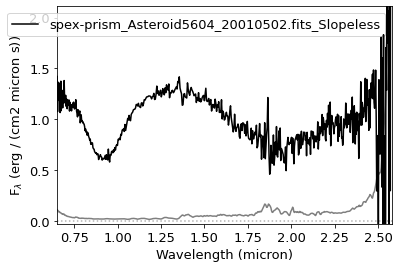

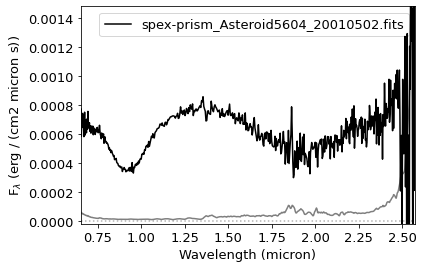

[<Figure size 432x288 with 1 Axes>]

In [7]:
curvSpec = splat.Spectrum('spex-prism_Asteroid5604_20010502.fits')
slopeless(curvSpec).plot()
curvSpec.plot()

In [11]:
folderDir = []
with os.scandir('SpeX_asteroid_spectra') as entries:
    for entry in entries:
        folderDir.append(entry.name)
        
resultsDict = {}
        
for item in folderDir:
    resultsDict[item] = classifyAsteroid(splat.Spectrum('SpeX_asteroid_spectra'+'/'+item), demeoDict)

In [20]:
results2Dict = {}
for item in folderDir:
    results2Dict[item] = classifyAsteroid(splat.Spectrum('SpeX_asteroid_spectra'+'/'+item), demeoDict, slope=False)

In [33]:
results2Dict

{'spex-prism_1036Ganymed_20010322.fits': ('Sr', <Quantity 8660.60405416>),
 'spex-prism_1036Ganymed_20010502.fits': ('Sv', <Quantity 5206.89215279>),
 'spex-prism_110Lydia-1_20010502.fits': ('X', <Quantity 97757.54186941>),
 'spex-prism_110Lydia-2-2_20010501.fits': ('Xk', <Quantity 17954.75130602>),
 'spex-prism_110Lydia-2_20010501.fits': ('Xk', <Quantity 16703.96468593>),
 'spex-prism_110Lydia-2_20010502.fits': ('X', <Quantity 28834.18744886>),
 'spex-prism_110Lydia-3_20010501.fits': ('Ch', <Quantity 54101.30114119>),
 'spex-prism_110Lydia-3_20010502.fits': ('X', <Quantity 45964.71768409>),
 'spex-prism_110Lydia-4_20010502.fits': ('X', <Quantity 31146.49036683>),
 'spex-prism_110Lydia_20010501.fits': ('Xk', <Quantity 40384.84571922>),
 'spex-prism_19356_20010501.fits': ('Sq', <Quantity 1457.39193312>),
 'spex-prism_1998SF36_20010322.fits': ('Q', <Quantity 72874.9855854>),
 'spex-prism_2000SS164_20010129.fits': ('O', <Quantity 290556.1741492>),
 'spex-prism_2000XG47_20010501.fits': ('S

In [64]:
rowe1 = []
rowe2 = []
roweResults = ['S','S',
               'Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk',
               '','','','',
               'Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk',
               'Xe','Xe','Xe',
               '',
               'Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk','Xk',
               'Sr',
               'V',
               'V',
               '',
               'Sw',
               'Sw',
               'Sq',
               '',
               '',
               '',
               'S',
               'K',
               'Sw',
               'Xk',
               '']

for i in folderDir:
    rowe1.append(i)
    
for j in roweResults:
     rowe2.append(j)
# print(rowe1,rowe2)

# dfrowe = pd.DataFrame(rowe1,rowe2, columns=['','Demeo et.al 2009'])
dfrowe = pd.DataFrame(columns=['','Demeo et.al 2009'])
dfrowe[''] = rowe1
dfrowe['Demeo et.al 2009'] = rowe2
print(dfrowe)

                                             Demeo et.al 2009
0       spex-prism_1036Ganymed_20010322.fits                S
1       spex-prism_1036Ganymed_20010502.fits                S
2        spex-prism_110Lydia-1_20010502.fits               Xk
3      spex-prism_110Lydia-2-2_20010501.fits               Xk
4        spex-prism_110Lydia-2_20010501.fits               Xk
5        spex-prism_110Lydia-2_20010502.fits               Xk
6        spex-prism_110Lydia-3_20010501.fits               Xk
7        spex-prism_110Lydia-3_20010502.fits               Xk
8        spex-prism_110Lydia-4_20010502.fits               Xk
9          spex-prism_110Lydia_20010501.fits               Xk
10            spex-prism_19356_20010501.fits                 
11         spex-prism_1998SF36_20010322.fits                 
12        spex-prism_2000SS164_20010129.fits                 
13         spex-prism_2000XG47_20010501.fits                 
14    spex-prism_201Penelope-1_20010502.fits               Xk
15    sp

TypeError: the first argument to axis() must be an interable of the form [xmin, xmax, ymin, ymax]

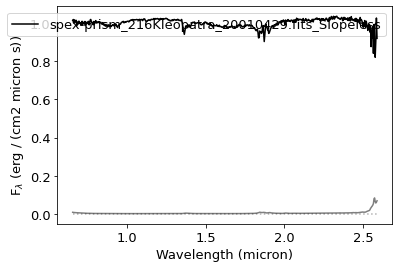

In [37]:
classifyAsteroid(splat.Spectrum('SpeX_asteroid_spectra/spex-prism_216Kleopatra_20010429.fits'), demeoDict, slope=False)

In [70]:
resultsDict

# data_items = resultsDict.items()
# data_list = list(resultsDict)
results2Dict
# publishedResults = pd.DataFrame[]

# df = pd.DataFrame(data_list)
# df
resultsSheet = pd.DataFrame.from_dict(resultsDict,orient='index', columns=['Classfied w/ Slope', 'chi^2'])
results2Sheet = pd.DataFrame.from_dict(results2Dict, orient='index', columns=['Classfied w/o Slope', 'chi^2'])
frames = [resultsSheet, results2Sheet]
res = pd.concat(frames, axis=1, join='inner')
res['Demeo et al. 2009'] = rowe2
res

,Classfied w/ Slope,chi^2,Classfied w/o Slope,chi^2,Demeo et al. 2009
spex-prism_1036Ganymed_20010322.fits,Sv,26964.242554507735,Sr,8660.60405416332,S
spex-prism_1036Ganymed_20010502.fits,Sv,5927.941073742017,Sv,5206.892152794075,S
spex-prism_110Lydia-1_20010502.fits,X,84201.08543678143,X,97757.54186940656,Xk
spex-prism_110Lydia-2-2_20010501.fits,X,17002.220707013883,Xk,17954.751306020713,Xk
spex-prism_110Lydia-2_20010501.fits,X,19766.235959567675,Xk,16703.964685933417,Xk
spex-prism_110Lydia-2_20010502.fits,Xk,28207.772626889397,X,28834.18744885608,Xk
spex-prism_110Lydia-3_20010501.fits,T,45286.90816825968,Ch,54101.30114118584,Xk
spex-prism_110Lydia-3_20010502.fits,Xk,59305.51812478649,X,45964.71768408679,Xk
spex-prism_110Lydia-4_20010502.fits,Xk,36843.28904706255,X,31146.49036682951,Xk
spex-prism_110Lydia_20010501.fits,T,42161.0794030527,Xk,40384.84571921569,Xk


In [24]:
results2Sheet

,Classfied w/o Slope,chi^2
spex-prism_1036Ganymed_20010322.fits,Sr,8660.60405416332
spex-prism_1036Ganymed_20010502.fits,Sv,5206.892152794075
spex-prism_110Lydia-1_20010502.fits,X,97757.54186940656
spex-prism_110Lydia-2-2_20010501.fits,Xk,17954.751306020713
spex-prism_110Lydia-2_20010501.fits,Xk,16703.964685933417
spex-prism_110Lydia-2_20010502.fits,X,28834.18744885608
spex-prism_110Lydia-3_20010501.fits,Ch,54101.30114118584
spex-prism_110Lydia-3_20010502.fits,X,45964.71768408679
spex-prism_110Lydia-4_20010502.fits,X,31146.49036682951
spex-prism_110Lydia_20010501.fits,Xk,40384.84571921569


In [17]:
saveTemplate('ast.bus-demeo.taxonomy/data/meanspectra.tab', saveName='Demeo_et_al_2009', classNames=DEMEO_CLASSES)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [8]:
demeoDict = {}

for name in DEMEO_CLASSES:
    demeoDict[name] = splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_'+ name +'.fits')

demeoDict

# exampleSpectra = splat.Spectrum('spex_prism_1658_20010129.fits')
# splat.compareSpectra(exampleSpectra, demeoDict.get('Sq'), range=[0.85,2.45], verbose=True, slope=False)
# slopeless(exampleSpectra).plot()
# exampleSpectra.plot()

{'A':  spectrum of Demeo_et_al_2009_A.fits,
 'B':  spectrum of Demeo_et_al_2009_B.fits,
 'C':  spectrum of Demeo_et_al_2009_C.fits,
 'Cb':  spectrum of Demeo_et_al_2009_Cb.fits,
 'Cg':  spectrum of Demeo_et_al_2009_Cg.fits,
 'Cgh':  spectrum of Demeo_et_al_2009_Cgh.fits,
 'Ch':  spectrum of Demeo_et_al_2009_Ch.fits,
 'D':  spectrum of Demeo_et_al_2009_D.fits,
 'K':  spectrum of Demeo_et_al_2009_K.fits,
 'L':  spectrum of Demeo_et_al_2009_L.fits,
 'O':  spectrum of Demeo_et_al_2009_O.fits,
 'Q':  spectrum of Demeo_et_al_2009_Q.fits,
 'R':  spectrum of Demeo_et_al_2009_R.fits,
 'S':  spectrum of Demeo_et_al_2009_S.fits,
 'Sa':  spectrum of Demeo_et_al_2009_Sa.fits,
 'Sq':  spectrum of Demeo_et_al_2009_Sq.fits,
 'Sr':  spectrum of Demeo_et_al_2009_Sr.fits,
 'Sv':  spectrum of Demeo_et_al_2009_Sv.fits,
 'T':  spectrum of Demeo_et_al_2009_T.fits,
 'V':  spectrum of Demeo_et_al_2009_V.fits,
 'X':  spectrum of Demeo_et_al_2009_X.fits,
 'Xc':  spectrum of Demeo_et_al_2009_Xc.fits,
 'Xe':  spec

In [68]:
classifyAsteroid(exampleSpectra, demeoDict, plot=False, slope=False)

('O', <Quantity 631044.33832449>)

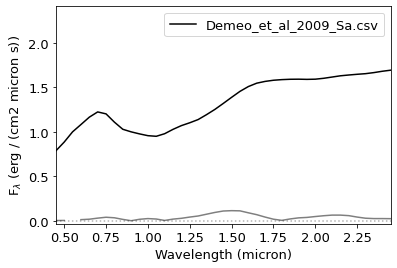

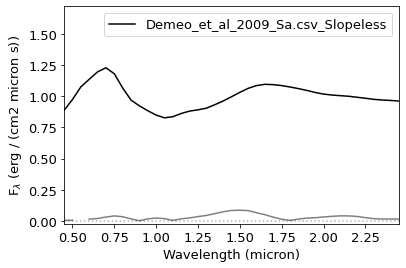

<Quantity [0.003, 0.004,   nan, 0.013, 0.018, 0.03 , 0.04 , 0.034, 0.016,
           0.001, 0.017, 0.025, 0.02 , 0.004, 0.019, 0.028, 0.042, 0.054,
           0.074, 0.094, 0.11 , 0.114, 0.112, 0.09 , 0.069, 0.042, 0.018,
           0.005, 0.021, 0.033, 0.038, 0.048, 0.057, 0.064, 0.064, 0.058,
           0.042, 0.029, 0.025, 0.025, 0.024] erg / (cm2 micron s)>

In [42]:
specc = splat.Spectrum('Demeo_et_al_2009_Folder/csv/Demeo_et_al_2009_Sa.csv')
specc.plot()
specc1 = slopeless(specc)
specc1.plot()
specc.noise

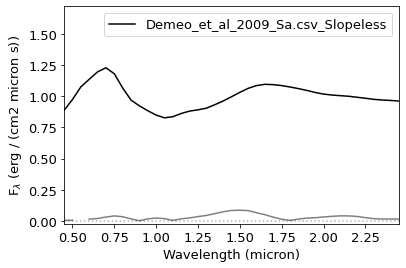

[<Figure size 432x288 with 1 Axes>]

In [44]:
specc2 = splat.Spectrum('Demeo_et_al_2009_Folder/csv/Demeo_et_al_2009_Sa.csv')
specc2 = slopeless(specc2)
specc2.plot()

In [6]:
fpx = splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_B.fits')
x = fpx.wave.value
y = fpx.flux.value
dy = fpx.noise.value

m,b = np.polyfit(x,y, 1) # returns m, b in y = mx + b, then use this with each value of fpx.wave as x to calculate line

tempArray2 = np.empty([len(x),1], dtype=float)
# print(tempArray2)


# for val in x:
#     np.append(tempArray1,(m*val+b))
# #     print(tempArray1)

print(y)

[0.978 0.989 1.    1.004 1.002 0.995 0.983 0.97  0.955 0.94  0.93  0.921
 0.912 0.905 0.898 0.892 0.885 0.879 0.876 0.873 0.868 0.861 0.859 0.858
 0.855 0.848 0.847 0.842 0.841 0.841 0.841 0.84  0.837 0.834 0.831 0.828
 0.825 0.82  0.814 0.808 0.803]


In [11]:
dyFinite = np.isfinite(dy)

dyFixed = np.empty_like(dy, dtype=float)

k = 0
for val in dy:
    if math.isnan(val):
        dyFixed[k] = 0
    else:
        dyFixed[k] = val
    k+=1

dyFixed

array([0.014, 0.011, 0.   , 0.017, 0.027, 0.035, 0.045, 0.056, 0.066,
       0.07 , 0.075, 0.081, 0.085, 0.09 , 0.092, 0.092, 0.092, 0.094,
       0.095, 0.095, 0.098, 0.101, 0.1  , 0.1  , 0.102, 0.105, 0.108,
       0.109, 0.109, 0.11 , 0.108, 0.107, 0.107, 0.112, 0.114, 0.114,
       0.114, 0.111, 0.11 , 0.112, 0.118])

In [12]:
tArrayFlux = np.empty_like(y, dtype=float)

tArray[1] = 2.0

n = 0
for val in x:
    tArrayFlux[n] = m*val+b
    n+=1

tArrayFlux

tArrayNoise = np.empty_like(dy, dtype=float)

mN,bN = np.polyfit(x,dyFixed, 1)

j = 0
for val in x:
    tArrayNoise[j] = mN*val+bN
    j+=1

tArrayNoise

NameError: name 'tArray' is not defined

In [144]:
dyFixed

array([0.014, 0.011, 0.   , 0.017, 0.027, 0.035, 0.045, 0.056, 0.066,
       0.07 , 0.075, 0.081, 0.085, 0.09 , 0.092, 0.092, 0.092, 0.094,
       0.095, 0.095, 0.098, 0.101, 0.1  , 0.1  , 0.102, 0.105, 0.108,
       0.109, 0.109, 0.11 , 0.108, 0.107, 0.107, 0.112, 0.114, 0.114,
       0.114, 0.111, 0.11 , 0.112, 0.118])

In [9]:
dyFixed/tArrayNoise

NameError: name 'tArrayNoise' is not defined

In [8]:
slopelessFlux = np.divide(y, tArrayFlux)
tDict = {}
tDict['wave'] = x
tDict['flux'] = slopelessFlux
tDict['noise'] = np.divide(dy, tArrayFlux)
spec1 = splat.Spectrum(tDict)
spec1.name = 'Demeo_et_al_2009_B_Slopeless'
spec1.plot()
fpx.plot()


fpx.noise

NameError: name 'tArrayFlux' is not defined

In [149]:
spec1.noise

<Quantity [0.01418515, 0.0112019 ,        nan, 0.01748913, 0.02791966,
           0.03637918, 0.04701619, 0.05881455, 0.069681  , 0.07429407,
           0.08002305, 0.0868858 , 0.09166531, 0.09758058, 0.10028966,
           0.10083616, 0.10138866, 0.10416349, 0.1058548 , 0.10644449,
           0.11042102, 0.11444235, 0.1139512 , 0.11460046, 0.1175623 ,
           0.1217175 , 0.12592086, 0.12782779, 0.12857746, 0.13052256,
           0.12890991, 0.12847873, 0.12925033, 0.13610748, 0.1393801 ,
           0.14023252, 0.14109544, 0.13823301, 0.13784112, 0.14122719,
           0.14973163] erg / (cm2 micron s)>

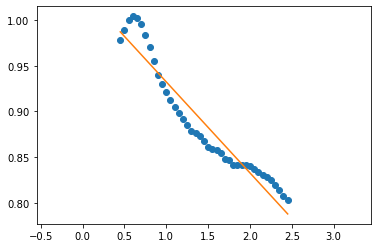

In [88]:
# get x and y vectors
x = fpx.wave.value
y = fpx.flux.value

# calculate polynomial
z = np.polyfit(x, y, 1)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()


In [10]:
readin = pd.read_csv('ast.bus-demeo.taxonomy/data/meanspectra.tab', sep=' ', header=None, index_col=0)
readin.index.name = 'wave'

tempDict = {}
classDictionary = {}
for j in DEMEO_CLASSES:
    classDictionary['Demeo_Class_'+j]= splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_'+j+'.fits')
    


In [11]:
classDictionary

{'Demeo_Class_A':  spectrum of Demeo_et_al_2009_A.fits,
 'Demeo_Class_B':  spectrum of Demeo_et_al_2009_B.fits,
 'Demeo_Class_C':  spectrum of Demeo_et_al_2009_C.fits,
 'Demeo_Class_Cb':  spectrum of Demeo_et_al_2009_Cb.fits,
 'Demeo_Class_Cg':  spectrum of Demeo_et_al_2009_Cg.fits,
 'Demeo_Class_Cgh':  spectrum of Demeo_et_al_2009_Cgh.fits,
 'Demeo_Class_Ch':  spectrum of Demeo_et_al_2009_Ch.fits,
 'Demeo_Class_D':  spectrum of Demeo_et_al_2009_D.fits,
 'Demeo_Class_K':  spectrum of Demeo_et_al_2009_K.fits,
 'Demeo_Class_L':  spectrum of Demeo_et_al_2009_L.fits,
 'Demeo_Class_O':  spectrum of Demeo_et_al_2009_O.fits,
 'Demeo_Class_Q':  spectrum of Demeo_et_al_2009_Q.fits,
 'Demeo_Class_R':  spectrum of Demeo_et_al_2009_R.fits,
 'Demeo_Class_S':  spectrum of Demeo_et_al_2009_S.fits,
 'Demeo_Class_Sa':  spectrum of Demeo_et_al_2009_Sa.fits,
 'Demeo_Class_Sq':  spectrum of Demeo_et_al_2009_Sq.fits,
 'Demeo_Class_Sr':  spectrum of Demeo_et_al_2009_Sr.fits,
 'Demeo_Class_Sv':  spectrum of 

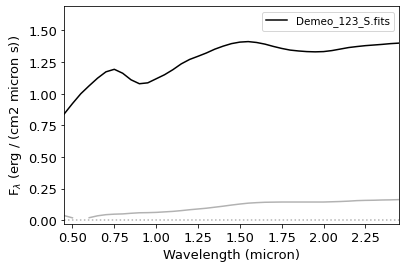

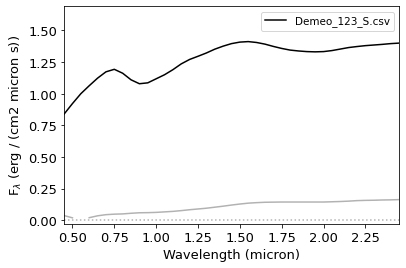

[<Figure size 432x288 with 1 Axes>]

In [12]:
# saveTemplate('ast.bus-demeo.taxonomy/data/meanspectra.tab', saveName = 'Demeo_123', classNames = DEMEO_CLASSES)
# schemeDict = {'S': splat.Spectrum('Demeo_et_al_2009_Folder/csv/Demeo_et_al_2009_S.csv')}
spu = splat.Spectrum('Demeo_123_Folder/fits/Demeo_123_S.fits')
spk = splat.Spectrum('Demeo_123_Folder/csv/Demeo_123_S.csv')
spu.plot()
spk.plot()

In [ ]:
schemeDict = {'S': splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_S.fits'), 'B': splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_B.fits')}

In [ ]:
print(schemeDict.get('S').flux[2])
schemeDict.get('S').flux

In [ ]:
schemeDict.get('S').wave

In [ ]:
slope = (schemeDict.get('S').flux[40] - schemeDict.get('S').flux[0])/2.0
slopelessSchemeDict = {}
slopelessSchemeDict['wave'] = schemeDict.get('S').wave
slopelessSchemeDict['flux'] = schemeDict.get('S').flux/((schemeDict.get('S').flux[40] - schemeDict.get('S').flux[0])/2.0)
slopelessSchemeDict['noise'] = schemeDict.get('S').noise
slopelessdf = pd.DataFrame(data=slopelessSchemeDict)

In [ ]:
slopelessSchemeDict, slope # values correct

In [ ]:
slopelessOne = splat.Spectrum(slopelessdf)
slopelessOne.plot()

In [ ]:
testSpectrum = schemeDict.get('B')
# testSpectrum.noise
svkd = slopeless(testSpectrum)
svkd.plot()
svkd.name = testSpectrum.name + '_slopeless'
svkd.name

In [ ]:
slopelessSchemeDict.get('S').plot(color='red')

In [ ]:
saveTemplate('ast.bus-demeo.taxonomy/data/meanspectra.tab', saveName='Demeo_et_al_2009', classNames=DEMEO_CLASSES)

In [ ]:
########
# main #
########

In [ ]:
classifyAsteroid(testSpectrum, classDictionary, slope=False)

In [ ]:
classifyAsteroid?

In [ ]:
plotSpectrum?

In [ ]:
schemeDict = {}

In [ ]:
spp2 = slopeless(splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_C.fits'))
spp1 = splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_C.fits')
plotSpectrum(spp1, spp2, color=['red','black'])
slopeless(splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_B.fits')).plot(color='red')
splat.Spectrum('Demeo_et_al_2009_Folder/fits/Demeo_et_al_2009_B.fits').plot(color='Black')

In [9]:
# os.makedirs('demeoFolder')
for item in DEMEO_CLASSES:
    sp = splat.Spectrum('demeoFolder/Demeo_Class_'+ item +'.fits')
    schemeDict[item] = sp
#     plotSpectrum(sp, color='red', legends='Demeo_Class_' + item ,filetype='pdf', filename='Demeo_Class_' + item + '.pdf')

schemeDict
schemeList = []
for item in schemeDict:
    schemeList.append(schemeDict.get(item))

elements = DEMEO_CLASSES
elements = ['Demeo_Class_{0}'.format(element) for element in elements]    
plotSpectrum(schemeList, multiplot=True, color='red', legends=elements, filetype='pdf',multipage=True, layout=[2,2], filename='Demeo_Classes_Combined.pdf')
# elements

ValueError: 
Cannot find file locally, and you do not have remote access

In [ ]:
# spx = splat.Spectrum('spex-prism_216Kleopatra_20010501.fits')

In [ ]:
splat.compareSpectra(spc, schemeDict.get('S'), mask_telluric=True, fit_ranges = [0.85, 2.45], novar2=True, plot=True)

In [ ]:
splat.compareSpectra(spc, schemeDict.get('Sv'), mask_telluric=True, fit_ranges = [0.85, 2.45], novar2=True, plot=True)

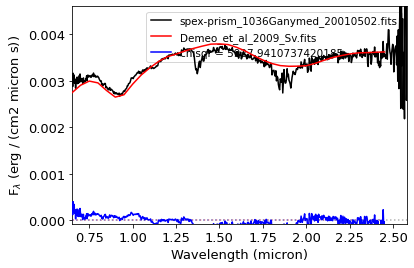

('Demeo_Class_Sv',
 <Quantity 5927.94107374>,
 {'Demeo_Class_A': <Quantity 413638.05568712>,
  'Demeo_Class_B': <Quantity 112023.9266552>,
  'Demeo_Class_C': <Quantity 55106.41821437>,
  'Demeo_Class_Cb': <Quantity 44129.93029275>,
  'Demeo_Class_Cg': <Quantity 45522.23455323>,
  'Demeo_Class_Cgh': <Quantity 30629.60490194>,
  'Demeo_Class_Ch': <Quantity 37758.53145129>,
  'Demeo_Class_D': <Quantity 61307.2229577>,
  'Demeo_Class_K': <Quantity 38382.18527047>,
  'Demeo_Class_L': <Quantity 33013.12907594>,
  'Demeo_Class_O': <Quantity 117911.07586242>,
  'Demeo_Class_Q': <Quantity 37541.13005363>,
  'Demeo_Class_R': <Quantity 67259.7633455>,
  'Demeo_Class_S': <Quantity 12612.67731976>,
  'Demeo_Class_Sa': <Quantity 181192.57370897>,
  'Demeo_Class_Sq': <Quantity 31607.28188731>,
  'Demeo_Class_Sr': <Quantity 11242.63981003>,
  'Demeo_Class_Sv': <Quantity 5927.94107374>,
  'Demeo_Class_T': <Quantity 30363.68596115>,
  'Demeo_Class_V': <Quantity 153263.99882759>,
  'Demeo_Class_X': <Quan

In [78]:
spc = splat.Spectrum('spex-prism_1036Ganymed_20010502.fits')
classifyAsteroid(spc, classDictionary, showAll=True, plot=True)
# Actual: Demeo 2009 1036 Ganymed S S S 09-Mar-05

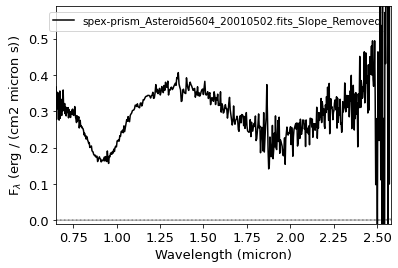

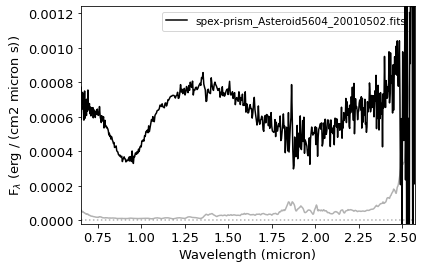

[<Figure size 432x288 with 1 Axes>]

In [98]:
# slopeless(classDictionary.get('B')).plot()
# slopeless(classDictionary.get('Demeo_Class_B')).noise
slopeless(spi).plot()
spi.plot()

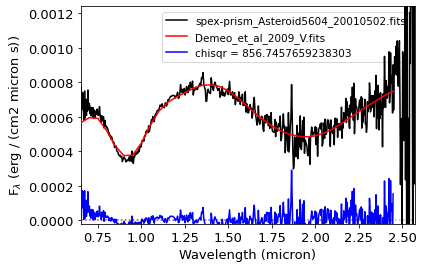

('Demeo_Class_V', <Quantity 856.74576592>)

In [19]:
spi = splat.Spectrum('spex-prism_Asteroid5604_20010502.fits')
# schemeDictV = {'V': schemeDict.get('V')}
classifyAsteroid(spi, classDictionary, plot=True, slope=True)
# classifyAsteroid(spi, classDictionary, showAll=True, plot=)
# Actual: Demeo 2009 5604 1992 FE V 29-Mar-01f

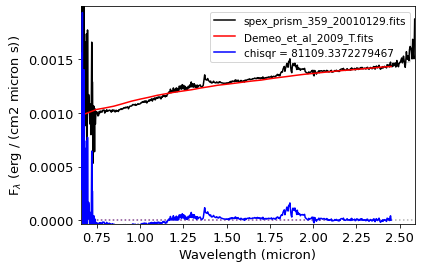

('Demeo_Class_T',
 <Quantity 81109.33722795>,
 {'Demeo_Class_A': <Quantity 5193066.18705484>,
  'Demeo_Class_B': <Quantity 1973449.89083807>,
  'Demeo_Class_C': <Quantity 384027.01010772>,
  'Demeo_Class_Cb': <Quantity 258466.03674756>,
  'Demeo_Class_Cg': <Quantity 325466.80142484>,
  'Demeo_Class_Cgh': <Quantity 302896.85872977>,
  'Demeo_Class_Ch': <Quantity 417976.80497224>,
  'Demeo_Class_D': <Quantity 302959.80477436>,
  'Demeo_Class_K': <Quantity 251404.50708343>,
  'Demeo_Class_L': <Quantity 525667.25406481>,
  'Demeo_Class_O': <Quantity 1845688.38986143>,
  'Demeo_Class_Q': <Quantity 227869.96224694>,
  'Demeo_Class_R': <Quantity 969237.06879574>,
  'Demeo_Class_S': <Quantity 155810.52037804>,
  'Demeo_Class_Sa': <Quantity 1793547.12738988>,
  'Demeo_Class_Sq': <Quantity 201891.40263853>,
  'Demeo_Class_Sr': <Quantity 282119.4422475>,
  'Demeo_Class_Sv': <Quantity 485444.74175546>,
  'Demeo_Class_T': <Quantity 81109.33722795>,
  'Demeo_Class_V': <Quantity 3770626.25831437>,
  

In [17]:
spk = splat.Spectrum('spex_prism_359_20010129.fits')
classifyAsteroid(spk, classDictionary, showAll=True, plot=True)
# Actual: Demeo 2009 110 Lydia M X Xk 29-Jan-01

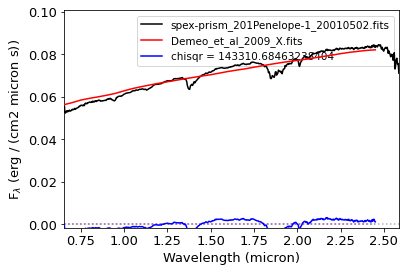

('Demeo_Class_X',
 <Quantity 143310.68463238>,
 {'Demeo_Class_A': <Quantity 8511627.93128407>,
  'Demeo_Class_B': <Quantity 4037986.02818769>,
  'Demeo_Class_C': <Quantity 652653.70215265>,
  'Demeo_Class_Cb': <Quantity 467562.12292903>,
  'Demeo_Class_Cg': <Quantity 622303.13472928>,
  'Demeo_Class_Cgh': <Quantity 746852.62268389>,
  'Demeo_Class_Ch': <Quantity 942084.63582135>,
  'Demeo_Class_D': <Quantity 443270.67741345>,
  'Demeo_Class_K': <Quantity 576601.71164681>,
  'Demeo_Class_L': <Quantity 1286184.05861865>,
  'Demeo_Class_O': <Quantity 3787068.34600931>,
  'Demeo_Class_Q': <Quantity 493765.11377951>,
  'Demeo_Class_R': <Quantity 1922203.55719816>,
  'Demeo_Class_S': <Quantity 559991.91106096>,
  'Demeo_Class_Sa': <Quantity 2812624.70871261>,
  'Demeo_Class_Sq': <Quantity 494337.20548441>,
  'Demeo_Class_Sr': <Quantity 866123.83602946>,
  'Demeo_Class_Sv': <Quantity 1383005.04827239>,
  'Demeo_Class_T': <Quantity 181390.9506714>,
  'Demeo_Class_V': <Quantity 8274916.56292806

In [16]:
spt = splat.Spectrum('spex-prism_201Penelope-1_20010502.fits')
# schemeDictShort = {'Xk':schemeDict.get('Xk')}
classifyAsteroid(spt, classDictionary, showAll=True, plot=True)
# inSpexElement(spt, schemeDict, showAll=True, plot=True)
# Actual: Demeo 2009 201 Penelope M X Xk 19-Feb-04